#Criminal Recidivism Risk Analysis for Parole Decisions with Themis ML Package


In [0]:
%pylab inline
import pandas as pd
import seaborn as sns

# filter dplyr warnings
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')

# print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls "/content/gdrive/Team Drives/Machine Learning with R/Project/Data/"

compas-scores-raw.csv  compas-scores-two-years.csv


**Discrimination Metric - Mean difference**

In [0]:
#pip install themis_ml

In [0]:
import themis_ml

In [0]:
from themis_ml.metrics import mean_difference

In [0]:
df = pd.read_csv("/content/gdrive/Team Drives/Machine Learning with R/Project/Data/compas-scores-two-years.csv")
df.head(5)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


**Selecting necessary variables**

In [0]:
df_two = df[['sex', 'age', 'race', 'juv_fel_count','juv_misd_count', 'juv_other_count', 'priors_count','days_b_screening_arrest','c_charge_degree','is_recid',]]

In [0]:
len(df_two)

7214

**Dropping NA's**

In [0]:
df2=df_two.dropna(axis=0)

In [0]:
df2.head()

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_charge_degree,is_recid
0,Male,69,Other,0,0,0,0,-1.0,F,0
1,Male,34,African-American,0,0,0,0,-1.0,F,1
2,Male,24,African-American,0,0,1,4,-1.0,F,1
5,Male,44,Other,0,0,0,0,0.0,M,0
6,Male,41,Caucasian,0,0,0,14,-1.0,F,1


In [0]:
len(df2)

6907

In [0]:
df2.race.value_counts()

African-American    3537
Caucasian           2378
Hispanic             584
Other                360
Asian                 32
Native American       16
Name: race, dtype: int64

**Selecting  'African-American' and 'Caucasian' race categories for analysis**

In [0]:
df_new = df2[(df2.race == 'African-American') | (df2.race == 'Caucasian')]

In [0]:
len(df_new)

5915

**creating dummy (0 - Male & 1- Female) & (0 - African-American & 1- caucasian)**

In [0]:
df_new["sex"] = df_new["sex"].map(
    lambda x: 1 if x == 'Female' else 0)

In [0]:
df_new["race"] = df_new["race"].map(
    lambda x: 0 if x == 'African-American' else 1)

**Y = is_recid**

In [0]:
Y = df_new.is_recid

Y.value_counts()

1    3016
0    2899
Name: is_recid, dtype: int64

In [0]:
sex = df_new["sex"]
sex.value_counts()

0    4751
1    1164
Name: sex, dtype: int64

In [0]:
race = df_new["race"]
race.value_counts()

0    3537
1    2378
Name: race, dtype: int64

**Calculating mean difference for protected class from raw dataset**

In [0]:
print("Mean difference scores:")
print("protected class = sex: %0.03f, 95%% CI [%0.03f-%0.03f]" %
      mean_difference(Y, sex))
# 0.0748013090229
print("protected class = race: %0.03f, 95%% CI [%0.03f-%0.03f]" %
      mean_difference(Y, race))
#0.199264685246

Mean difference scores:
protected class = sex: 0.139, 95% CI [0.107-0.170]
protected class = race: 0.139, 95% CI [0.113-0.165]


###The mean differences above suggest that men and African-Americans are more likely to reoffend compared to women and Caucasians.**

In [0]:
df_new.head()

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_charge_degree,is_recid
1,0,34,0,0,0,0,0,-1.0,F,1
2,0,24,0,0,0,1,4,-1.0,F,1
6,0,41,1,0,0,0,14,-1.0,F,1
8,1,39,1,0,0,0,0,-1.0,M,0
9,0,21,1,0,0,0,1,428.0,F,1


**generating dummies**

In [0]:
X = pd.get_dummies(df_new,columns=['c_charge_degree'])

In [0]:
X.columns

Index(['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'days_b_screening_arrest',
       'is_recid', 'c_charge_degree_F', 'c_charge_degree_M'],
      dtype='object')

**Defining different feature sets for different models**

In [0]:
from sklearn.model_selection import train_test_split

# load model-ready data
training_data = X
training_data.head()

# define feature sets:
# 1. including protected attributes
features = ['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'days_b_screening_arrest',
       'is_recid', 'c_charge_degree_F', 'c_charge_degree_M']
# 2. removing variables related to sex
features_no_sex = ['age', 'race', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'days_b_screening_arrest',
       'is_recid', 'c_charge_degree_F', 'c_charge_degree_M']

# 3. removing variables related to race
features_no_race = ['sex', 'age', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'days_b_screening_arrest',
       'is_recid', 'c_charge_degree_F', 'c_charge_degree_M']

X = training_data[features].values
X_no_sex = training_data[features_no_sex].values
X_no_race = training_data[features_no_race].values
y = Y.values
s_sex = sex.values
s_race = race.values

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,is_recid,c_charge_degree_F,c_charge_degree_M
1,0,34,0,0,0,0,0,-1.0,1,1,0
2,0,24,0,0,0,1,4,-1.0,1,1,0
6,0,41,1,0,0,0,14,-1.0,1,1,0
8,1,39,1,0,0,0,0,-1.0,0,0,1
9,0,21,1,0,0,0,1,428.0,1,1,0


**Running different models(baseline , RPA, ROC, ACF) with 5-fold cross validation**

In [0]:

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.base import clone

from themis_ml.postprocessing.reject_option_classification import \
    SingleROClassifier
from themis_ml.linear_model import LinearACFClassifier

METRICS_COLUMNS = [
    "mean_diff_sex", "mean_diff_race", "auc_sex", "auc_race"]


def run_experiment_iteration(
        X, X_no_sex, X_no_race, y, s_sex, s_race, train, test):
    """Run the experiment on a particular set of train and test indices."""
    
    # store our metrics here. This will be a list of lists, where the inner
    # list is contains the following metadata:
    # - "name"
    # - fairness metric with respect to sex
    # - fairness metric with respect to race
    # - utility metric with respect to sex
    # - utility metric with respect to race
    metrics = []

    # define our model.
    logistic_clf = LogisticRegression(penalty="l2", C=0.001, class_weight="balanced")
    baseline_clf = logistic_clf
    rpa_clf = logistic_clf
    roc_clf = SingleROClassifier(estimator=logistic_clf)
    acf_clf = LinearACFClassifier(
        target_estimator=logistic_clf,
        binary_residual_type="absolute")

    # train baseline model
    baseline_clf.fit(X[train], y[train])
    baseline_preds = baseline_clf.predict(X[test])
    baseline_auc = roc_auc_score(y[test], baseline_preds)
    metrics.append([
        "B",
        mean_difference(baseline_preds, s_sex[test])[0],
        mean_difference(baseline_preds, s_race[test])[0],
        baseline_auc, baseline_auc  # repeated because the two AUC values are the
                                    # same in the baseline case
    ])

    # train "remove protected attributes" model. Here we have to train two
    # seperate ones for sex and race.

    # model trained with no explicitly sex-related variables
    rpa_preds_no_sex = rpa_clf.fit(
        X_no_sex[train], y[train]).predict(X_no_sex[test])
    # model trained with no explicitly race-related variables
    rpa_preds_no_race = rpa_clf.fit(
        X_no_race[train], y[train]).predict(X_no_race[test])
    metrics.append([
        "RPA",
        mean_difference(rpa_preds_no_sex, s_sex[test])[0],
        mean_difference(rpa_preds_no_race, s_race[test])[0],
        roc_auc_score(y[test], rpa_preds_no_sex),
        roc_auc_score(y[test], rpa_preds_no_race),
    ])

    # train reject-option classification model.
    roc_clf.fit(X[train], y[train])
    roc_preds_sex = roc_clf.predict(X[test], s_sex[test])
    roc_preds_race = roc_clf.predict(X[test], s_race[test])
    metrics.append([
        "ROC",
        mean_difference(roc_preds_sex, s_sex[test])[0],
        mean_difference(roc_preds_race, s_race[test])[0],
        roc_auc_score(y[test], roc_preds_sex),
        roc_auc_score(y[test], roc_preds_race),
    ])

    # train additive counterfactually fair model.
    acf_preds_sex = acf_clf.fit(
        X[train], y[train], s_sex[train]).predict(X[test], s_sex[test])
    acf_preds_race = acf_clf.fit(
        X[train], y[train], s_race[train]).predict(X[test], s_race[test])
    metrics.append([
        "ACF",
        mean_difference(acf_preds_sex, s_sex[test])[0],
        mean_difference(acf_preds_race, s_race[test])[0],
        roc_auc_score(y[test], acf_preds_sex),
        roc_auc_score(y[test], acf_preds_race),
    ])

    # convert metrics list of lists into dataframe
    return pd.DataFrame(
        metrics, columns=["condition"] + METRICS_COLUMNS)


Running cross-validation experiment...


Text(0.5, 1.0, 'Fairness (mean diff) and Utility (auc) Metrics')

,mean(mean_diff_sex),mean(mean_diff_race),mean(auc_sex),mean(auc_race)
condition,,,,
B,0.170964,0.225361,0.894819,0.894819
RPA,0.163594,0.220592,0.894391,0.895070
ROC,0.172880,0.184840,0.762372,0.762372
ACF,0.073800,0.062998,0.883807,0.877298


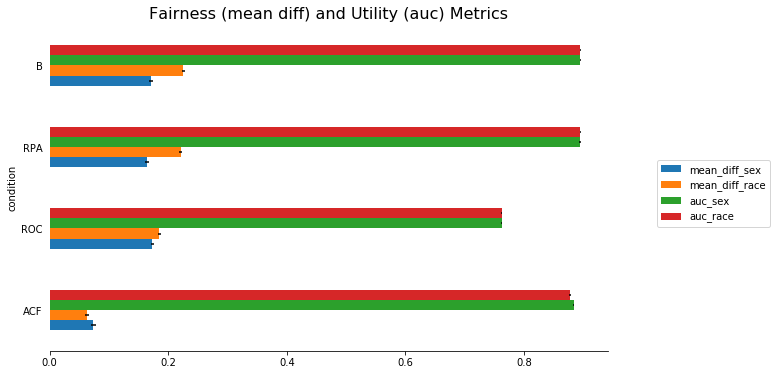

In [0]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

N_SPLITS = 5
N_REPEATS = 20

# add these two binary variables so that we can stratify the observations
# by protected class
groups = np.add(s_sex, s_race)

# do 5-fold, 10x repeating cross validation so that we quantify the
# uncertainty around our metrics estimates.
cv = RepeatedStratifiedKFold(
    n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=41)

metrics = []
print("Running cross-validation experiment...")
for i, (train_idx, test_idx) in enumerate(cv.split(X, y, groups=groups)):
    metrics.append(
        run_experiment_iteration(
            X, X_no_sex, X_no_race, y, s_sex, s_race, train_idx, test_idx)
        .assign(rep_fold=i))

# concatenate metrics from all cv-folds
metrics = pd.concat(metrics)

# compute mean point estimate for each metric and each condition
group_df = metrics.groupby("condition")
mean_metrics = (
    group_df
    [METRICS_COLUMNS].mean()
)
# compute standard error of the mean
stderr_metrics = (
    group_df
    [METRICS_COLUMNS].std()
) / np.sqrt(N_REPEATS * N_SPLITS)

# plot vertical bar chart
ax = mean_metrics.loc[reversed(["B", "RPA", "ROC", "ACF"])].plot(
    kind="barh", figsize=(10, 6),
    xerr=stderr_metrics.loc[reversed(["B", "RPA", "ROC", "ACF"])],
    legend=False);
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 0.6))
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='y', which='both', left='off')
ax.set_title(
    "Fairness (mean diff) and Utility (auc) Metrics", fontsize=16);

mean_metrics.loc[["B", "RPA", "ROC", "ACF"]].rename(
    columns=lambda x: "mean(%s)" % x)

In [0]:
mean_metrics.loc[["B", "RPA", "ROC", "ACF"]].rename(
    columns=lambda x: "mean(%s)" % x)

,mean(mean_diff_sex),mean(mean_diff_race),mean(auc_sex),mean(auc_race)
condition,,,,
B,0.170964,0.225361,0.894819,0.894819
RPA,0.163594,0.220592,0.894391,0.895070
ROC,0.172880,0.184840,0.762372,0.762372
ACF,0.073800,0.062998,0.883807,0.877298


##Conclusion:

####For the bias to be treated, there is a trade-off to be made between the fairness and the utility. 
Ideally, we would prefer for the mean difference to be low and the accuracy to be high. 
However, as we can see in the graph, although for B and RPA classifiers the accuracy is high, the mean-difference is also high.

And for ROC and ACF, as the mean difference is decreasing, it is dragging the accuracy along with it.

####So, with this trade off, we think ACF is th best classifier to go ahead with as the mean difference is significantly lower than B and RPA, however, the accuracy does not seem to drop that much. 

(This tradeoff depends on one's own trade-off conditions as it changes across datasets and also the problem statement we are dealing with)
